In [13]:
import os
# from google.colab import drive
# from os.path import join as jn
# import shutil

# # 구글 드라이브 접근
# ROOT = "/content/drive"
# try:
#   drive.mount(ROOT, force_remount=True)
# except:
#   drive.mount(ROOT)
ROOT = os.getcwd()

Mounted at /content/drive


# tutorial

* ref : https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## install

In [3]:
%%shell
 
pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-anoxkkyj
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-anoxkkyj
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263915 sha256=941f0006164cc24529b102593ecd8b782e375f14a210f26ac47f03c5553b8b66
  Stored in directory: /tmp/pip-ephem-wheel-cache-543m3qyt/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.3
    Uninstalling pycocotools-2.0.3:
      Successfully uninstalled pycocotools-2.0.3


In [4]:
%%shell
# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip
rm PennFudanPed.zip

--2021-12-08 13:05:52--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  22.9MB/s    in 2.2s    

2021-12-08 13:05:55 (22.9 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2021-12-08 13:05:55--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-12-08 13:05:55--
Total wall clock time: 2.6s
Downloaded: 1 files, 51M in 2.2s (22.9 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

* structure

```tree
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

```python
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
```

## dataset

In [5]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
 
 
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
 
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
 
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
 
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
 
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

## model

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
 
# num_classes == custom data num_classes
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO,,,resnet50(backbone), fpn(head)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
 
    return model

## install pytorch API

In [7]:
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
 
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../
# multi-machine, multi-gpu
# cp references/detection/train.py

Cloning into 'vision'...
remote: Enumerating objects: 62268, done.
remote: Counting objects: 100% (2039/2039), done.
remote: Compressing objects: 100% (601/601), done.
remote: Total 62268 (delta 1817), reused 1548 (delta 1430), pack-reused 60229
Receiving objects: 100% (62268/62268), 116.47 MiB | 11.31 MiB/s, done.
Resolving deltas: 100% (50585/50585), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [15]:
# from torchvision.models.detection import _utils
# from torchvision import datasets

## preprocess

In [8]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
 
 
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


## test : forward() method

In [95]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)

# train
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections

# inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

# /usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
#   return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

In [96]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

## example script

In [20]:
%%writefile main.py

if __name__=="main":
    from engine import train_one_epoch, evaluate
    import utils


    def main():
        # train on the GPU or on the CPU, if a GPU is not available
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        # our dataset has two classes only - background and person
        num_classes = 2
        # use our dataset and defined transformations
        dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
        dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

        # split the dataset in train and test set
        indices = torch.randperm(len(dataset)).tolist()
        dataset = torch.utils.data.Subset(dataset, indices[:-50])
        dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

        # define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=2, shuffle=True, num_workers=4,
            collate_fn=utils.collate_fn)

        data_loader_test = torch.utils.data.DataLoader(
            dataset_test, batch_size=1, shuffle=False, num_workers=4,
            collate_fn=utils.collate_fn)

        # get the model using our helper function
        model = get_model_instance_segmentation(num_classes)

        # move model to the right device
        model.to(device)

        # construct an optimizer
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=0.005,
                                    momentum=0.9, weight_decay=0.0005)
        # and a learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)

        # let's train it for 10 epochs
        num_epochs = 10

        for epoch in range(num_epochs):
            # train for one epoch, printing every 10 iterations
            train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
            # update the learning rate
            lr_scheduler.step()
            # evaluate on the test dataset
            evaluate(model, data_loader_test, device=device)

        print("That's it!")

Writing main.py


In [28]:
%load main.py
%load engine.py
%load coco_eval.py
%load coco_utils.py
%load transforms.py
%load utils.py

In [29]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [33]:
main()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Epoch: [0]  [ 0/60]  eta: 0:01:03  lr: 0.000090  loss: 3.7507 (3.7507)  loss_classifier: 0.8241 (0.8241)  loss_box_reg: 0.2478 (0.2478)  loss_mask: 2.6065 (2.6065)  loss_objectness: 0.0639 (0.0639)  loss_rpn_box_reg: 0.0083 (0.0083)  time: 1.0648  data: 0.3318  max mem: 2008
Epoch: [0]  [10/60]  eta: 0:00:17  lr: 0.000936  loss: 1.4178 (1.8862)  loss_classifier: 0.4866 (0.4995)  loss_box_reg: 0.3096 (0.3301)  loss_mask: 0.6793 (1.0206)  loss_objectness: 0.0287 (0.0304)  loss_rpn_box_reg: 0.0058 (0.0057)  time: 0.3518  data: 0.0355  max mem: 2527
Epoch: [0]  [20/60]  eta: 0:00:12  lr: 0.001783  loss: 0.9596 (1.3440)  loss_classifier: 0.2166 (0.3492)  loss_box_reg: 0.2735 (0.2928)  loss_mask: 0.3434 (0.6690)  loss_objectness: 0.0243 (0.0273)  loss_rpn_box_reg: 0.0050 (0.0058)  time: 0.2751  data: 0.0063  max mem: 2527
Epoch: [0]  [30/60]  eta: 0:00:09  lr: 0.002629  loss: 0.6503 (1.0830)  loss_classifier: 0.1041 (0.2604)  loss_box_reg: 0.2384 (0.2704)  loss_mask: 0.2360 (0.5237)  loss_ob

return 값이 없기 때문에 모델이 돌아가는지 확인용으로 사용하면 되는가???? 아니면 코드 내 마지막 부분만 수정해서 save.model??

## train(Recommend do not run)

In [35]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
 
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
 
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
 
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
 
# our dataset has two classes only - background and person
num_classes = 2
 
# get the model using our helper function
model = get_model_instance_segmentation(num_classes)
# move model to the right device
model.to(device)
 
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
 
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [40]:
# let's train it for 10 epochs
num_epochs = 10
 
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:00:38  lr: 0.000090  loss: 2.7771 (2.7771)  loss_classifier: 0.7481 (0.7481)  loss_box_reg: 0.3405 (0.3405)  loss_mask: 1.6637 (1.6637)  loss_objectness: 0.0224 (0.0224)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 0.6491  data: 0.3435  max mem: 3080
Epoch: [0]  [10/60]  eta: 0:00:16  lr: 0.000936  loss: 1.3766 (1.7236)  loss_classifier: 0.5181 (0.4835)  loss_box_reg: 0.2961 (0.2970)  loss_mask: 0.7153 (0.9197)  loss_objectness: 0.0140 (0.0185)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 0.3253  data: 0.0351  max mem: 3080
Epoch: [0]  [20/60]  eta: 0:00:12  lr: 0.001783  loss: 1.0073 (1.2283)  loss_classifier: 0.2189 (0.3358)  loss_box_reg: 0.2885 (0.2844)  loss_mask: 0.3205 (0.5876)  loss_objectness: 0.0113 (0.0161)  loss_rpn_box_reg: 0.0042 (0.0045)  time: 0.2832  data: 0.0049  max mem: 3080
Epoch: [0]  [30/60]  eta: 0:00:09  lr: 0.002629  loss: 0.5712 (1.0137)  loss_classifier: 0.0937 (0.2561)  loss_box_reg: 0.2701 (0.2839)  loss_mask: 0.1826 (0.4539)  loss_ob

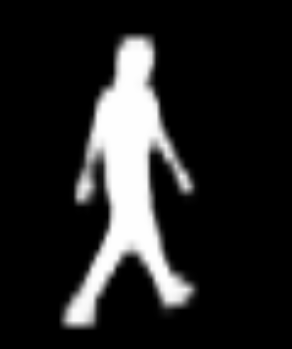

In [41]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
 
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())


# check shape of datasets("PennFudanPed")

* tutorial까지 돌아간 코드에서 shape 확인하고 customize...근데 사용한 metric?module?이 다른 걸 보면 아예 데이터 입력 방식이 다른 것일 수도...

In [48]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
 
# # split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [45]:
type(dataset_test)

__main__.PennFudanDataset

In [42]:
type(dataset_test)

torch.utils.data.dataset.Subset

In [43]:
type(data_loader_test)

torch.utils.data.dataloader.DataLoader

In [51]:
dataset[0]

(tensor([[[1.0000, 0.9922, 0.9804,  ..., 0.5098, 0.5059, 0.5176],
          [1.0000, 0.9922, 0.9804,  ..., 0.4549, 0.3961, 0.4549],
          [1.0000, 0.9922, 0.9804,  ..., 0.4863, 0.4745, 0.5529],
          ...,
          [0.5059, 0.4863, 0.4667,  ..., 0.3294, 0.3255, 0.3216],
          [0.5216, 0.4980, 0.4745,  ..., 0.2941, 0.2941, 0.2941],
          [0.5451, 0.5176, 0.4824,  ..., 0.3020, 0.2980, 0.2941]],
 
         [[1.0000, 0.9882, 0.9765,  ..., 0.6627, 0.6667, 0.6745],
          [1.0000, 0.9882, 0.9765,  ..., 0.6078, 0.5569, 0.6118],
          [1.0000, 0.9882, 0.9765,  ..., 0.6471, 0.6353, 0.7137],
          ...,
          [0.5686, 0.5490, 0.5294,  ..., 0.3843, 0.3804, 0.3765],
          [0.5843, 0.5608, 0.5373,  ..., 0.3451, 0.3412, 0.3451],
          [0.6118, 0.5843, 0.5490,  ..., 0.3373, 0.3294, 0.3294]],
 
         [[0.9843, 0.9725, 0.9608,  ..., 0.2980, 0.3059, 0.3255],
          [0.9843, 0.9725, 0.9608,  ..., 0.2431, 0.1961, 0.2627],
          [0.9843, 0.9725, 0.9608,  ...,

In [78]:
type(dataset[0])

tuple

In [52]:
dataset[0][1].keys()

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])

In [56]:
print(dataset[0][1]['area'].shape)

torch.Size([1])


In [81]:
print(f"0번째 train 이미지")
print(f"\t 이미지 shape : {dataset[0][0].shape}\n\t 이미지 type : {dataset[0][0].type()}")
for k in list(dataset[0][1].keys()):
     print(f"\t\tdict_keys == '{k}' :  \n\t\t\tshape : {dataset[0][1][k].shape}\n\t\t\ttype : {dataset[0][1][k].type()}")
     if k is not "masks":
         print(f"\t\t\t{dataset[0][1][k]}")

0번째 train 이미지
	 이미지 shape : torch.Size([3, 321, 398])
	 이미지 type : torch.FloatTensor
		dict_keys == 'boxes' :  
			shape : torch.Size([1, 4])
			type : torch.FloatTensor
			tensor([[170.,  21., 319., 311.]])
		dict_keys == 'labels' :  
			shape : torch.Size([1])
			type : torch.LongTensor
			tensor([1])
		dict_keys == 'masks' :  
			shape : torch.Size([1, 321, 398])
			type : torch.ByteTensor
		dict_keys == 'image_id' :  
			shape : torch.Size([1])
			type : torch.LongTensor
			tensor([155])
		dict_keys == 'area' :  
			shape : torch.Size([1])
			type : torch.FloatTensor
			tensor([43210.])
		dict_keys == 'iscrowd' :  
			shape : torch.Size([1])
			type : torch.LongTensor
			tensor([0])


In [88]:
print(dataset[0][1]['labels'])
print(torch.stack([dataset[0][1]['labels'], dataset[0][1]['labels']]))
# torch.uint8 -> torch.ByteTensor
# torch.float16 -> torch.HalfTensor
# torch.float, torch.float32 -> torch.FloatTensor
# torch.int16 -> torch.ShortTensor
# torch.int, torch.int32 -> torch.IntTensor
# torch.int64 -> torch.LongTensor
# torch.float64 -> torch.DoubleTensor

# list -> tensor ; torch.as_tensor
# list


tensor([1])
tensor([[1],
        [1]])


In [92]:
dataset[0][1]['masks'][0]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

masks를 확인하고, 다른 값들을 확인한 결과,,
    * mask 생성 무조건 해야함!!!
    * 형태(모델을 돌리는 방법)는 자유겠지만, 그 각각을 맞추려면 CustomDataset(default)에서 CustomDataset(multi class or process)로 진행되어야 함.

* DataLoader

operation이 어떻게 작용되는지 확인하기

In [10]:
 # use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
 
# # split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
 
 # define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
 
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)